In [1]:
import os
import datetime
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

In [2]:
def printmd(string):
    display(Markdown(string))

In [32]:
def load_blinks(subject, cond):
    path = '../eye_openess_features/' + subject + '/' + cond + '/'
    all_status_rates = []
    all_wrong_frames = []
    lst = os.listdir(path)
    num_parts = int(len(lst) / 2)

    for num in range(1, num_parts+1):
        status_rates = list(np.load(path + "status_rates_part" + str(num) + ".npy"))
        wrong_frames = list(np.load(path + "wrong_frames_part" + str(num) + ".npy"))

        all_status_rates = all_status_rates + status_rates
        all_wrong_frames = all_wrong_frames + wrong_frames
    return all_status_rates, all_wrong_frames

In [33]:
# Finds eye-blinks given a sequence of values and a treshhold.
def find_blinks(values, treshhold, wrong_frames, start_frame):
    blink = False
    blinks = []
    blink_count = 0
    wrong_count = 0
    for i, val in enumerate(values):
        if val < treshhold:
            if blink == False:
                blink_count +=1
                start = i
            blink = True
            if (i + start_frame + 1) in wrong_frames:
                wrong_count += 1
        else:
            if blink == True:
                end = i - 1
                #calculate duration of blink, and include in tuple
                duration = end - start + 1
                duration = duration - wrong_count
                wrong_count = 0
                
                blinks.append((start, end, duration))
                #print("Blinking period: " + str(start) + " - " + str(end))
            blink = False
    return blinks, blink_count

In [34]:
# Extracts features in a segment from given blinks
def blinks_segment(blink_starts, blink_durs, video_len, segment_len):
    # the amount of frames at the end that are not taken into account
    rest = video_len % segment_len
    num_frames = video_len - rest
    blink_counts = []
    average_durs = []
    
    blink_count = 0
    dur_count = 0
    
    # a blink is counted to a segment,when the blink starts in that segment
    for frame in range(num_frames):
        if frame % 30000 == 0:
            print(frame)
        # only happens at the end of a segment
        if frame % segment_len == 0 and frame != 0:
            #print('new_segment', frame)
            blink_counts.append(blink_count)
            if dur_count > 0:
                avg_dur = dur_count / blink_count
            else:
                avg_dur = 0
            average_durs.append(avg_dur)
            blink_count = 0 
            dur_count = 0
        # happens when a blink starts
        if frame in blink_starts:
            frame_index = blink_starts.index(frame)
            blink_count += 1
            dur_count += blink_durs[frame_index]
            
    return blink_counts, average_durs

In [195]:
subject = 'subject1'

sleepy_start_frame = 0
normal_start_frame = 0

print('start loading')
status_rates_sleepy, wrong_frames_sleepy = load_blinks(subject, 'sleepy') 
print("Sleepy number of frames: ", len(status_rates_sleepy))
print("Sleepy missed faces: ", len(wrong_frames_sleepy))
status_rates_normal, wrong_frames_normal = load_blinks(subject, 'normal') 
print("Normal number of frames: ", len(status_rates_normal))
print("Normal missed faces: ", len(wrong_frames_normal))

start loading
Sleepy number of frames:  150002
Sleepy missed faces:  1767
Normal number of frames:  163001
Normal missed faces:  4034


## Subject-level Analysis

In [196]:
def run_analysis(status_rates, wrong_frames, treshhold, segment_length, start_frame=0):
    blinks, count = find_blinks(status_rates, treshhold, wrong_frames, start_frame)
    print("Number of blinks: ", len(blinks))

    blink_starts = list(np.array(blinks)[:,0])
    blink_durs = list(np.array(blinks)[:,2])

    blink_counts, average_durs = blinks_segment(blink_starts, blink_durs, len(status_rates), segment_length)
    print("Number of segments", len(blink_counts))
    print("Mean blink count per segment", np.mean(blink_counts))
    print("Mean blink duration per segment", np.mean(average_durs))
    return blink_counts, average_durs


def plot_analysis(subject, blink_counts, average_durs, save_counts=False, save_durs=False):
    # Plotting blink counts
    plt.title("Blink counts of a " + str(segment_length) + " frame segment for " + subject)
    plt.xlabel('Frame segment')
    plt.ylabel('Blink counts')
    plt.plot(range(len(blink_counts)), blink_counts)
    if save_counts != False:
        plt.savefig(save_counts)
    plt.show()

    # Plotting average blink durations
    plt.title("Average blink duration of a frame segment")
    plt.xlabel('Frame segment')
    plt.ylabel('Average blink duration')
    plt.plot(range(len(average_durs)), average_durs)
    if save_durs != False:
        plt.savefig(save_durs)
    plt.show()

Number of blinks:  2545
0
30000
60000
90000
120000
Number of segments 53
Mean blink count per segment 46.58490566037736
Mean blink duration per segment 5.887194065951866


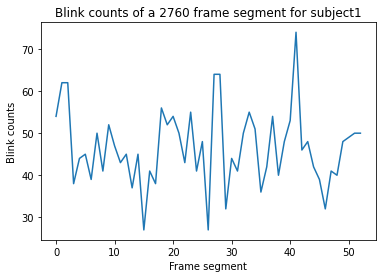

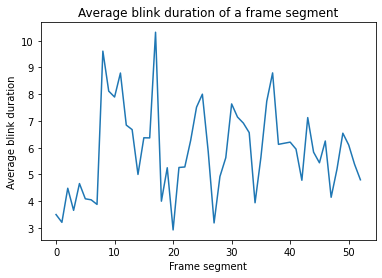

In [197]:
treshhold = 10
segment_length = int(2760)

blink_counts_sleepy, average_durs_sleepy = run_analysis(status_rates_sleepy, wrong_frames_sleepy, treshhold, segment_length, start_frame = sleepy_start_frame)
plot_analysis(subject, blink_counts_sleepy, average_durs_sleepy)

Number of blinks:  3731
0
30000
60000
90000
120000
150000
Number of segments 58
Mean blink count per segment 63.36206896551724
Mean blink duration per segment 3.2710650337231173


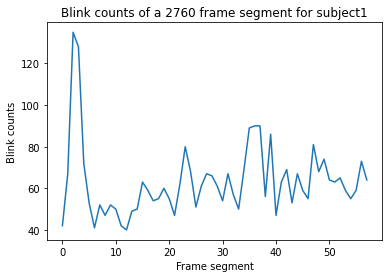

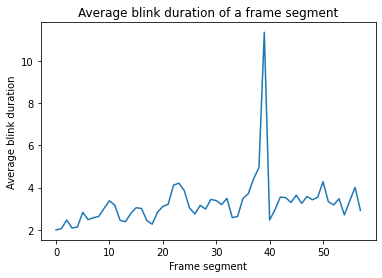

In [198]:
blink_counts_normal, average_durs_normal = run_analysis(status_rates_normal, wrong_frames_normal, treshhold, segment_length, start_frame=normal_start_frame)
plot_analysis(subject, blink_counts_normal, average_durs_normal)

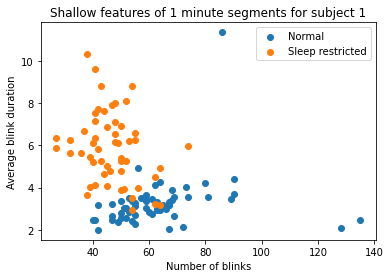

In [199]:
# make a scatter plot of the two classes
plt.title("Shallow features of 1 minute segments for subject " + subject[-1:])
plt.xlabel("Number of blinks")
plt.ylabel("Average blink duration")
plt.scatter(blink_counts_normal, average_durs_normal, label = 'Normal')
plt.scatter(blink_counts_sleepy, average_durs_sleepy, label = 'Sleep restricted')
plt.legend()
plt.savefig('../final_figures/scatter_plot_' + subject + '.jpg')
plt.show()

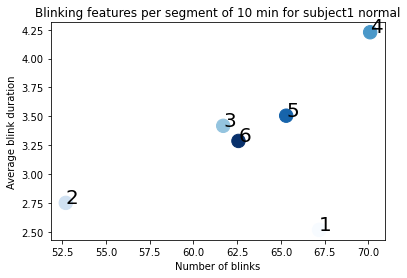

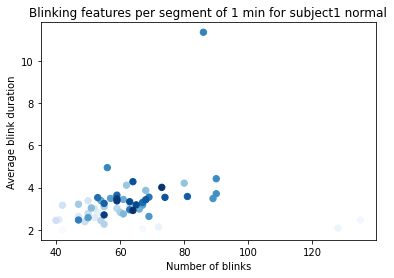

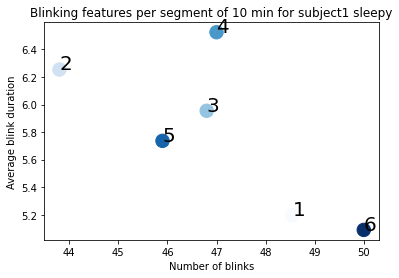

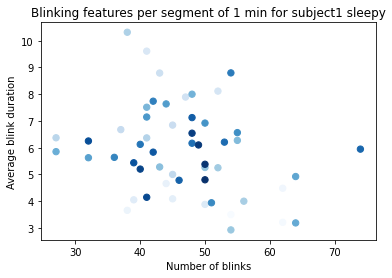

In [200]:
def gradient_plot(blink_counts, average_durs, condition, time, size=40, text = False):
    plt.title("Blinking features per segment of " + time + " min for " + subject + ' ' + condition)
    plt.xlabel("Number of blinks")
    plt.ylabel("Average blink duration")
    plt.scatter(blink_counts, average_durs, label = 'Normal', cmap = 'Blues', c = range(len(blink_counts)), s=size)
    if text:
        for i in range(len(blink_counts)):
            plt.annotate(i + 1, (blink_counts[i], average_durs[i]), fontsize = 20)

    plt.savefig('../figures/gradient_scatter_' + subject + condition + time + '_min.jpg')
    plt.show()

def average(values, avg_len):
    new_values = []
    sum_values = []
    for i, val in enumerate(values):
        sum_values.append(val)
        if i % avg_len == 0 and i > 0:
            new_values.append(sum(sum_values) / len(sum_values))
            sum_values = []
    new_values.append(sum(sum_values) / len(sum_values))
    return new_values

avg_len = 10
avg_counts_normal = average(blink_counts_normal, avg_len)
avg_avg_durs_normal = average(average_durs_normal, avg_len)

gradient_plot(avg_counts_normal, avg_avg_durs_normal, 'normal', str(avg_len), size=180, text = True)
gradient_plot(blink_counts_normal, average_durs_normal, 'normal', '1')
plt.show()

avg_len = 10
avg_counts_sleepy = average(blink_counts_sleepy, avg_len)
avg_avg_durs_sleepy = average(average_durs_sleepy, avg_len)

gradient_plot(avg_counts_sleepy, avg_avg_durs_sleepy, 'sleepy', str(avg_len), size=180, text = True)
gradient_plot(blink_counts_sleepy, average_durs_sleepy, 'sleepy', '1')
plt.show()

53 53
53
Mean number of blink frames sleepy:  270.2641509433962
Mean number of blink frames normal:  211.63793103448276


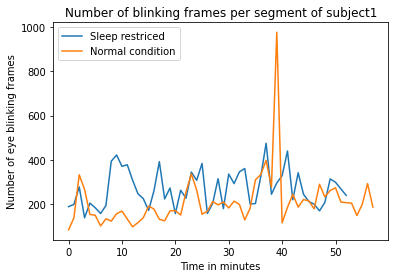

In [201]:
# The number of blinking frames is just a multiplication of the duration and number of blinks
blink_frames_sleepy = list(np.multiply(np.array(blink_counts_sleepy), np.array(average_durs_sleepy)))
blink_frames_normal = list(np.multiply(np.array(blink_counts_normal), np.array(average_durs_normal)))

print(len(blink_counts_sleepy), len(average_durs_sleepy))
print(len(blink_frames_sleepy))
print("Mean number of blink frames sleepy: ", np.mean(blink_frames_sleepy))
print("Mean number of blink frames normal: ", np.mean(blink_frames_normal))

# Plotting blink frames in one plot.
plt.plot(range(len(blink_frames_sleepy)) , blink_frames_sleepy, label = 'Sleep restriced')
plt.plot(range(len(blink_frames_normal)), blink_frames_normal, label = 'Normal condition')
plt.title('Number of blinking frames per segment of ' + subject)
plt.legend()
plt.xlabel('Time in minutes')
plt.ylabel('Number of eye blinking frames')
plt.savefig('../figures/blink_frames_'+ subject + '.jpg')
plt.show()

## Additional code

[(5, 6, 2), (8, 9, 2), (13, 13, 1), (26, 26, 1), (28, 29, 2), (31, 32, 2), (35, 35, 1), (39, 40, 2), (46, 47, 2), (55, 55, 1)]


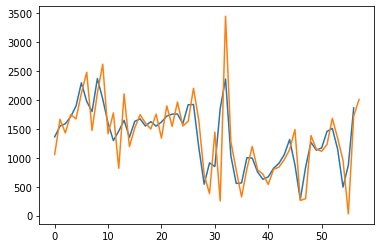

In [160]:
def interesting_segments(values, threshold):
    interesting = False
    segments = []
    for i, val in enumerate(values):
        if val > threshold:
            if interesting == False:
                start = i
            interesting = True
        else:
            if interesting == True:
                end = i - 1
                #calculate duration of blink, and include in tuple
                duration = end - start + 1
                segments.append((start, end, duration))
                #print("Blinking period: " + str(start) + " - " + str(end))
            interesting = False
    return segments

def interesting_segments_std(values):
    interesting = False
    segments = []

    std = np.std(values)
    mean = np.mean(values)

    t1 = mean + std
    t2 = mean - std

    for i, val in enumerate(values):
        if val > t1:
            if interesting == False:
                start = i
            interesting = True

        elif val < t2:
            if interesting == False:
                start = i
            interesting = True

        else:
            if interesting == True:
                end = i - 1
                #calculate duration of blink, and include in tuple
                duration = end - start + 1
                segments.append((start, end, duration))
                #print("Blinking period: " + str(start) + " - " + str(end))
            interesting = False
    return segments

def moving_average(values, length):
    ma_values = np.convolve(values, np.ones(length), 'valid') / length
    plt.plot(range(len(ma_values)), ma_values)
    plt.plot(range(len(values)), values)
    plt.show()


print(interesting_segments_std(blink_frames_sleepy))
moving_average(blink_frames_sleepy, 2)
#def interesting_segment_std(values):

In [ ]:
def t_test(normal_vals, sleepy_vals):
    print("Var: ", np.var(normal_vals), np.var(sleepy_vals))
    print("Std: ", np.std(normal_vals), np.std(sleepy_vals))
    print("Mean: ", np.mean(normal_vals), np.mean(sleepy_vals))
    t_score = stats.ttest_ind(normal_vals, sleepy_vals, equal_var=False)
    print("T-test P Val ", t_score[1])
    w_score = stats.wilcoxon(normal_vals[:len(sleepy_vals)], sleepy_vals)
    print("Wilcoxon P Val ", w_score[1])
    

printmd("Blink duration")
t_test(average_durs_normal, average_durs_sleepy)

printmd("Blink count")
t_test(blink_counts_normal, blink_counts_sleepy)

printmd("Blink frames")
t_test(blink_frames_normal, blink_frames_sleepy)

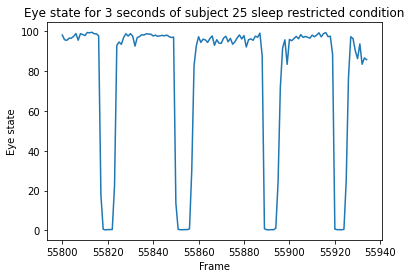

In [20]:
# look at the blinks more in depth
# DONT change these parameters
frame_start = 0
frame_end = len(status_rates_sleepy)  # normal sleep: last frame is 2804    restricted sleep: last frame is 2774 
frames = range(frame_start, frame_end + 1)

# CHANGE these parameter
frame_start = 55800
frame_end = 55935

plt.title("Eye state for 3 seconds of subject 25 sleep restricted condition")
plt.xlabel('Frame')
plt.ylabel('Eye state')
plt.plot(frames[frame_start:frame_end], status_rates_sleepy[frame_start:frame_end])
plt.show()

In [ ]:
def find_microsleeps(status_rates, threshhold, top_n = 10, fps = 46):
    blinks, count = find_blinks(status_rates, threshhold)
    longest_blinks = sorted(blinks, key=lambda x: x[2], reverse=True)[:top_n]
    blink_starts_sec = list(np.array(longest_blinks)[:, 0] / fps)
    for i in range(top_n):
        print("Top " + str(i + 1) + " : ")
        print("Duration: " + str(longest_blinks[i][2]))
        print("Start : " + str(datetime.timedelta(seconds=blink_starts_sec[i])))
    print(blink_starts_sec[:top_n])
    print(longest_blinks)


find_microsleeps(status_rates_normal, 10, 10, 46)

## Multiple subjects

In [73]:
status_rates_1s, wrong_frames_1s = load_blinks('subject1', 'sleepy', 3)
status_rates_1n, wrong_frames_1n = load_blinks('subject1', 'normal', 4)

status_rates_3s, wrong_frames_3s = load_blinks('subject3', 'sleepy', 2) 
status_rates_3n, wrong_frames_3n = load_blinks('subject3', 'normal', 2) 

status_rates_4s, wrong_frames_4s = load_blinks('subject4', 'sleepy', 1) 
status_rates_4n, wrong_frames_4n = load_blinks('subject4', 'normal', 1)

treshhold = 10
segment_length = int(2760)

blink_counts_1s, average_durs_1s = run_analysis(status_rates_1s, wrong_frames_1s, treshhold, segment_length)
blink_counts_1n, average_durs_1n = run_analysis(status_rates_1n, wrong_frames_1n, treshhold, segment_length)
print("done with sub1") 
blink_counts_3s, average_durs_3s = run_analysis(status_rates_3s, wrong_frames_3s, treshhold, segment_length)
blink_counts_3n, average_durs_3n = run_analysis(status_rates_3n, wrong_frames_3n, treshhold, segment_length)
print("done with sub3")
blink_counts_4s, average_durs_4s = run_analysis(status_rates_4s, wrong_frames_4s, treshhold, segment_length)
blink_counts_4n, average_durs_4n = run_analysis(status_rates_4n, wrong_frames_4n, treshhold, segment_length)

TypeError: load_blinks() takes 2 positional arguments but 3 were given

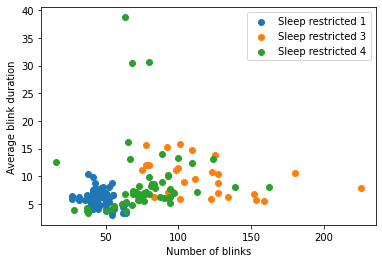

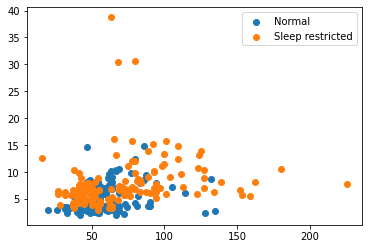

Blink counts
Var:  315.8324433368933 1156.659367779878
Std:  17.77167531036096 34.00969520269004
Mean:  57.62264150943396 72.9927536231884
T-test P Val  3.766760458795879e-06
Wilcoxon P Val  8.975919718437859e-05
Blink duration
Var:  5.828365020193747 23.034197311300364
Std:  2.414200700064878 4.799395515197759
Mean:  4.882478256221578 7.854776369555283
T-test P Val  4.5887938305222057e-10
Wilcoxon P Val  3.516482080842434e-14
Blink frames
Var:  41496.13179858392 229785.443236715
Std:  203.70599352641523 479.35940925021487
Mean:  293.1383647798742 607.1666666666666
T-test P Val  2.372645269757697e-11
Wilcoxon P Val  7.343526039573077e-13


In [116]:
plt.xlabel("Number of blinks")
plt.ylabel("Average blink duration")

#plt.scatter(blink_counts_1n, average_durs_1n, label = 'Normal 1')
plt.scatter(blink_counts_1s, average_durs_1s, label = 'Sleep restricted 1')

#plt.scatter(blink_counts_3n, average_durs_3n, label = 'Normal 3')
plt.scatter(blink_counts_3s, average_durs_3s, label = 'Sleep restricted 3')

#plt.scatter(blink_counts_4n, average_durs_4n, label = 'Normal 4')
plt.scatter(blink_counts_4s, average_durs_4s, label = 'Sleep restricted 4')

plt.legend()
plt.savefig('../figures/scatter_plot_1min_multi-subjects_sleepy.jpg')
plt.show()

blink_counts_all_sleepy = blink_counts_1s + blink_counts_3s + blink_counts_4s
average_durs_all_sleepy = average_durs_1s + average_durs_3s + average_durs_4s

blink_counts_all_normal = blink_counts_1n + blink_counts_3n + blink_counts_4n
average_durs_all_normal = average_durs_1n + average_durs_3n + average_durs_4n

plt.scatter(blink_counts_all_normal, average_durs_all_normal, label = 'Normal')
plt.scatter(blink_counts_all_sleepy, average_durs_all_sleepy, label = 'Sleep restricted')
plt.legend()
plt.savefig('../figures/scatter_plot_1min_multi-subjects_merged.jpg')
plt.show()

blink_frames_all_sleepy = list(np.multiply(np.array(blink_counts_all_sleepy), np.array(average_durs_all_sleepy)))
blink_frames_all_normal = list(np.multiply(np.array(blink_counts_all_normal), np.array(average_durs_all_normal)))

print("Blink counts")
t_test(blink_counts_all_normal, blink_counts_all_sleepy)

print("Blink duration")
t_test(average_durs_all_normal, average_durs_all_sleepy)

print("Blink frames")
t_test(blink_frames_all_normal, blink_frames_all_sleepy)